**install**

In [1]:
!pip install --upgrade tensorflow==2.12.0 tensorflow-addons==0.21.0
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
!pip install -q kaggle
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayaehabsalama","key":"455042fd2c61af709713bfc2d12e899f"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d shreelakshmigp/cedardataset
!unzip cedardataset.zip -d data

Dataset URL: https://www.kaggle.com/datasets/shreelakshmigp/cedardataset
License(s): unknown
Archive:  cedardataset.zip
  inflating: data/signatures/Readme.txt  
  inflating: data/signatures/full_forg/Thumbs.db  
  inflating: data/signatures/full_forg/forgeries_10_1.png  
  inflating: data/signatures/full_forg/forgeries_10_10.png  
  inflating: data/signatures/full_forg/forgeries_10_11.png  
  inflating: data/signatures/full_forg/forgeries_10_12.png  
  inflating: data/signatures/full_forg/forgeries_10_13.png  
  inflating: data/signatures/full_forg/forgeries_10_14.png  
  inflating: data/signatures/full_forg/forgeries_10_15.png  
  inflating: data/signatures/full_forg/forgeries_10_16.png  
  inflating: data/signatures/full_forg/forgeries_10_17.png  
  inflating: data/signatures/full_forg/forgeries_10_18.png  
  inflating: data/signatures/full_forg/forgeries_10_19.png  
  inflating: data/signatures/full_forg/forgeries_10_2.png  
  inflating: data/signatures/full_forg/forgeries_10_20.pn

In [5]:
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install Pillow
!pip install keras
!pip install opencv-python


In [6]:
import os
import random
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import layers, models, applications, backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_curve, auc
from PIL import Image
from datetime import datetime
import tensorflow_addons as tfa

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
print(os.listdir('data'))

['signatures']


In [8]:
print(os.listdir('data/signatures'))

['full_forg', 'full_org', 'Readme.txt']


**Load Data**

In [9]:
org_path = 'data/signatures/full_org'
forg_path = 'data/signatures/full_forg'

original_files = sorted([f for f in os.listdir(org_path) if f.endswith('.png')])
forged_files = sorted([f for f in os.listdir(forg_path) if f.endswith('.png')])

def parse_filename(filename):
    try:
        if filename.startswith('original_'):
            parts = filename.split('_')
            person_id = int(parts[1])
            sample_num = int(parts[2].split('.')[0])
            return person_id, sample_num, 'original'
        elif filename.startswith('forgeries_'):
            parts = filename.split('_')
            person_id = int(parts[1])
            sample_num = int(parts[2].split('.')[0])
            return person_id, sample_num, 'forgery'
    except:
        return None, None, None

signature_db = {}
for file in original_files:
    person_id, _, _ = parse_filename(file)
    if person_id is not None:
        if person_id not in signature_db:
            signature_db[person_id] = {'original': [], 'forgery': []}
        signature_db[person_id]['original'].append(file)

for file in forged_files:
    person_id, _, _ = parse_filename(file)
    if person_id is not None:
        if person_id not in signature_db:
            signature_db[person_id] = {'original': [], 'forgery': []}
        signature_db[person_id]['forgery'].append(file)

signature_db = {k: v for k, v in signature_db.items() if len(v['original']) >= 2 and len(v['forgery']) >= 1}

print(f"Number of original signatures: {sum(len(v['original']) for v in signature_db.values())}")
print(f"Number of forged signatures: {sum(len(v['forgery']) for v in signature_db.values())}")
print(f"Total unique persons: {len(signature_db)}")
print(f"Samples per person - Original: {len(signature_db[list(signature_db.keys())[0]]['original'])}, Forged: {len(signature_db[list(signature_db.keys())[0]]['forgery'])}")

Number of original signatures: 1320
Number of forged signatures: 1320
Total unique persons: 55
Samples per person - Original: 24, Forged: 24


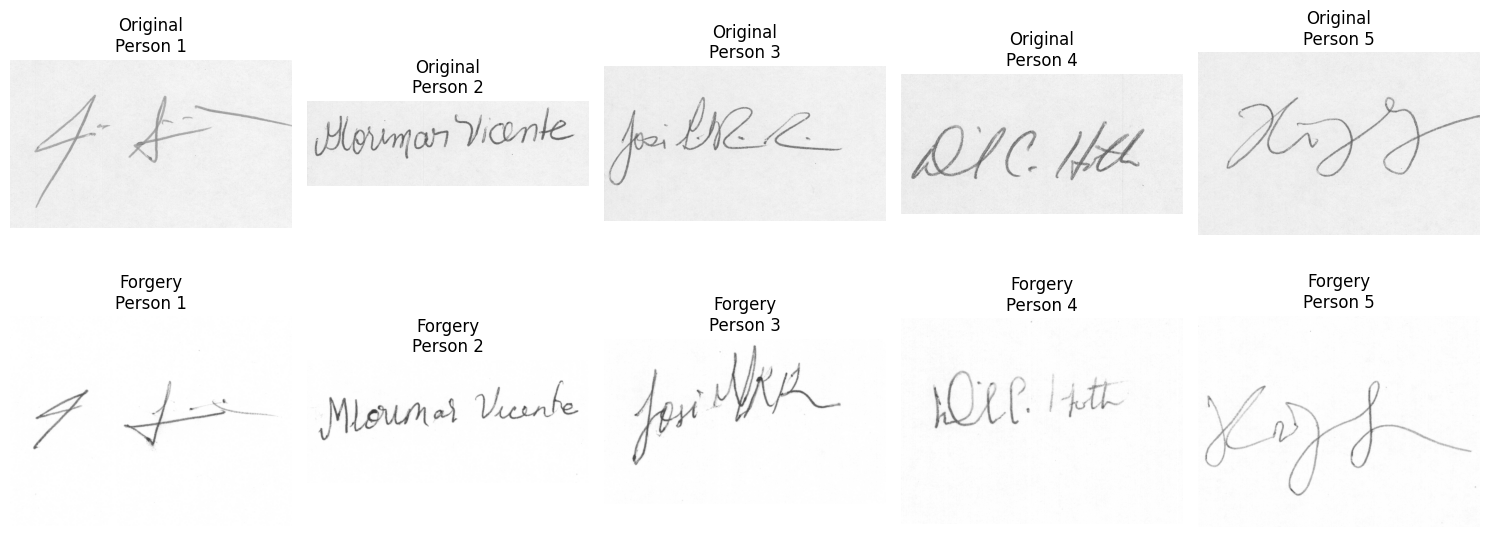

In [10]:
plt.figure(figsize=(15, 6))
display_count = 0
for person_id in sorted(signature_db.keys())[:5]:

    plt.subplot(2, 5, display_count+1)
    img = load_img(os.path.join(org_path, signature_db[person_id]['original'][0]))
    plt.imshow(img)
    plt.title(f"Original\nPerson {person_id}")
    plt.axis('off')

    plt.subplot(2, 5, display_count+6)
    img = load_img(os.path.join(forg_path, signature_db[person_id]['forgery'][0]))
    plt.imshow(img)
    plt.title(f"Forgery\nPerson {person_id}")
    plt.axis('off')

    display_count += 1
    if display_count >= 5:
        break
plt.tight_layout()
plt.show()

**Data Augmentation**

In [11]:
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EMBEDDING_DIM = 256

def preprocess_image(filepath):
    img = load_img(filepath, target_size=IMG_SIZE, color_mode='rgb')
    img = img_to_array(img)
    img = img / 255.0
    return img.astype('float32')

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.02),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
])

**Generate Triplets**

In [15]:
def get_hard_triplets(embeddings, labels, num_hard=10):
    """
    Generate hard triplets based on the current embeddings

    Args:
        embeddings: numpy array of shape (batch_size, embedding_dim)
        labels: numpy array of shape (batch_size,)
        num_hard: number of hard triplets to return

    Returns:
        indices of anchors, positives, negatives for hard triplets
    """

    pairwise_dist = np.sqrt(np.sum(np.square(
        np.expand_dims(embeddings, 1) - np.expand_dims(embeddings, 0)
    ), axis=2))

    anchors = []
    positives = []
    negatives = []

    for i in range(len(labels)):

        pos_indices = np.where(labels == labels[i])[0]
        pos_indices = pos_indices[pos_indices != i]


        neg_indices = np.where(labels != labels[i])[0]

        if len(pos_indices) == 0 or len(neg_indices) == 0:
            continue


        hardest_pos = pos_indices[np.argmax(pairwise_dist[i, pos_indices])]


        hardest_neg = neg_indices[np.argmin(pairwise_dist[i, neg_indices])]

        anchors.append(i)
        positives.append(hardest_pos)
        negatives.append(hardest_neg)


    if len(anchors) > num_hard:
        selected = np.random.choice(len(anchors), num_hard, replace=False)
        return (
            np.array(anchors)[selected],
            np.array(positives)[selected],
            np.array(negatives)[selected]
        )
    return np.array(anchors), np.array(positives), np.array(negatives)

In [16]:
def generate_triplets(signature_db, org_path, forg_path, batch_size=32, seed=42, hard_mining=False, model=None):
    person_ids = list(signature_db.keys())
    while True:
        selected_ids = random.choices(person_ids, k=batch_size)
        anchors, positives, negatives = [], [], []

        for person_id in selected_ids:
            orig_samples = signature_db[person_id]['original']
            forg_samples = signature_db[person_id]['forgery']


            anchor, positive = random.sample(orig_samples, 2)


            if len(forg_samples) > 0:
                rand_val = random.random()
                if rand_val < 0.7:
                    negative = random.choice(forg_samples)
                    neg_path = forg_path
                elif rand_val < 0.85:
                    other_person = random.choice([p for p in person_ids if p != person_id])
                    negative = random.choice(signature_db[other_person]['original'])
                    neg_path = org_path
                else:
                    other_person = random.choice([p for p in person_ids if p != person_id])
                    if len(signature_db[other_person]['forgery']) > 0:
                        negative = random.choice(signature_db[other_person]['forgery'])
                        neg_path = forg_path
                    else:
                        negative = random.choice(signature_db[other_person]['original'])
                        neg_path = org_path
            else:
                other_person = random.choice([p for p in person_ids if p != person_id])
                negative = random.choice(signature_db[other_person]['original'])
                neg_path = org_path


            anchor_img = preprocess_image(os.path.join(org_path, anchor))
            positive_img = preprocess_image(os.path.join(org_path, positive))
            negative_img = preprocess_image(os.path.join(neg_path, negative))

            anchors.append(anchor_img)
            positives.append(positive_img)
            negatives.append(negative_img)


        if hard_mining and model:

            embeddings = model.predict([np.array(anchors), np.array(positives), np.array(negatives)], verbose=0)


            anchors_emb = embeddings[0]
            positives_emb = embeddings[1]
            negatives_emb = embeddings[2]


            all_embeddings = np.concatenate([anchors_emb, positives_emb, negatives_emb])
            labels = np.array([0]*len(anchors_emb) + [0]*len(positives_emb) + [1]*len(negatives_emb))


            anchor_idx, pos_idx, neg_idx = get_hard_triplets(all_embeddings, labels, num_hard=batch_size)


            anchors = np.array(anchors)[anchor_idx % len(anchors)]
            positives = np.array(positives)[pos_idx % len(positives)]
            negatives = np.array(negatives)[neg_idx % len(negatives)]

        yield [np.array(anchors), np.array(positives), np.array(negatives)], np.zeros((batch_size,))

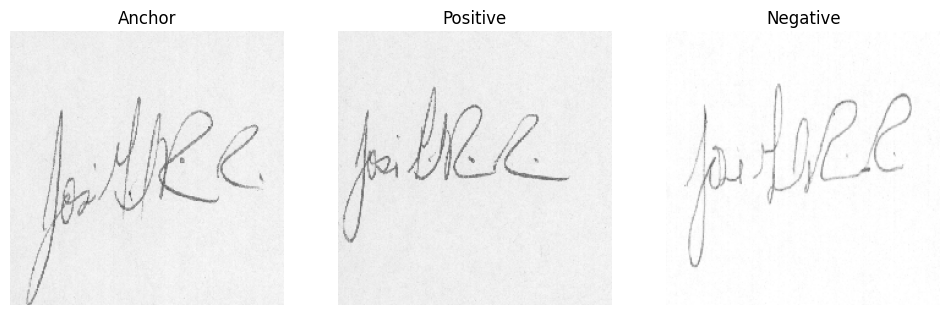

In [18]:
triplet_gen = generate_triplets(signature_db, org_path, forg_path, batch_size=1)
(anchor, positive, negative), _ = next(triplet_gen)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(anchor[0])
plt.title("Anchor")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(positive[0])
plt.title("Positive")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(negative[0])
plt.title("Negative")
plt.axis('off')
plt.show()

**Split Data**

In [19]:
person_ids = list(signature_db.keys())
train_ids, test_ids = train_test_split(person_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=42)

print(f"Training persons: {len(train_ids)}")
print(f"Validation persons: {len(val_ids)}")
print(f"Test persons: {len(test_ids)}")




Training persons: 38
Validation persons: 8
Test persons: 9


In [20]:
train_db = {pid: signature_db[pid] for pid in train_ids}
val_db = {pid: signature_db[pid] for pid in val_ids}
test_db = {pid: signature_db[pid] for pid in test_ids}


def calculate_steps(db, batch_size):
    return max(1, len(db) * 2 // batch_size)

train_steps = calculate_steps(train_db, BATCH_SIZE)
val_steps = calculate_steps(val_db, BATCH_SIZE)
test_steps = calculate_steps(test_db, BATCH_SIZE)

print(f"\nTraining steps per epoch: {train_steps}")
print(f"Validation steps: {val_steps}")
print(f"Test steps: {test_steps}")





Training steps per epoch: 2
Validation steps: 1
Test steps: 1


**Model**

In [21]:
def create_embedding_model(input_shape):
    base_model = applications.DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='max'
    )


    for layer in base_model.layers[:-30]:
        layer.trainable = False



    inputs = layers.Input(input_shape)
    x = data_augmentation(inputs)
    x = base_model(x)


    x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(EMBEDDING_DIM, activation='linear', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)


    output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

    return models.Model(inputs, output)

def create_siamese_model(input_shape, embedding_model):

    anchor_input = layers.Input(input_shape, name='anchor_input')
    positive_input = layers.Input(input_shape, name='positive_input')
    negative_input = layers.Input(input_shape, name='negative_input')


    embedding_network = embedding_model
    anchor_embedding = embedding_network(anchor_input)
    positive_embedding = embedding_network(positive_input)
    negative_embedding = embedding_network(negative_input)


    pos_distance = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), axis=-1)
    neg_distance = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), axis=-1)


    accuracy = tf.reduce_mean(tf.cast(pos_distance < neg_distance, tf.float32))


    siamese_network = models.Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=[anchor_embedding, positive_embedding, negative_embedding]
    )


    siamese_network.add_metric(accuracy, name='accuracy')

    return siamese_network


embedding_model = create_embedding_model(INPUT_SHAPE)
siamese_model = create_siamese_model(INPUT_SHAPE, embedding_model)


triplet_loss = tfa.losses.TripletHardLoss(margin=0.4)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
siamese_model.compile(optimizer=optimizer, loss=triplet_loss)

siamese_model.summary()

74836368/74836368 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                           

**Generator**

In [22]:
def get_fixed_generator(db, org_path, forg_path, batch_size, seed=42, hard_mining=False, model=None):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    return generate_triplets(db, org_path, forg_path, batch_size,hard_mining=hard_mining, model=model)

train_generator = generate_triplets(train_db, org_path, forg_path, BATCH_SIZE,seed=42,hard_mining=True, model=siamese_model)
val_generator = get_fixed_generator(val_db, org_path, forg_path, BATCH_SIZE,seed=42,hard_mining=False)
test_generator = get_fixed_generator(test_db, org_path, forg_path, BATCH_SIZE,seed=42)

In [23]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-8,
    verbose=1,
    mode='min'
)



history = siamese_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=100,
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 6.6273 - model_loss: 0.4000 - model_1_loss: 0.4000 - model_2_loss: 0.4000 - accuracy: 0.6562  
Epoch 1: val_accuracy improved from -inf to 0.92188, saving model to best_model.h5
2/2 [==============================] - 152s 86s/step - loss: 6.6273 - model_loss: 0.4000 - model_1_loss: 0.4000 - model_2_loss: 0.4000 - accuracy: 0.6562 - val_loss: 6.5880 - val_model_loss: 0.4000 - val_model_1_loss: 0.4000 - val_model_2_loss: 0.4000 - val_accuracy: 0.9219 - lr: 1.0000e-04
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 6.5748 - model_loss: 0.4000 - model_1_loss: 0.4000 - model_2_loss: 0.4000 - accuracy: 0.6250 
Epoch 2: val_accuracy did not improve from 0.92188
2/2 [==============================] - 96s 71s/step - loss: 6.5748 - model_loss: 0.4000 - model_1_loss: 0.4000 - model_2_loss: 0.4000 - accuracy: 0.6250 - val_loss: 6.5355 - val_model_loss: 0.4000 - val_model_1_loss: 0.4000 - val_model_2_loss: 0.4000 

**Evaluation**

In [24]:
siamese_model.load_weights('best_model.h5')

def evaluate_model(db, org_path, forg_path, steps, batch_size, name, seed=42):
    generator = get_fixed_generator(db, org_path, forg_path, batch_size, seed)
    distances_pos = []
    distances_neg = []

    for _ in range(steps):
        (anchor, positive, negative), _ = next(generator)
        anchor_emb, pos_emb, neg_emb = siamese_model.predict([anchor, positive, negative], verbose=0)

        dist_pos = np.linalg.norm(anchor_emb - pos_emb, axis=1)
        dist_neg = np.linalg.norm(anchor_emb - neg_emb, axis=1)

        distances_pos.extend(dist_pos)
        distances_neg.extend(dist_neg)

    accuracy = np.mean(np.array(distances_pos) < np.array(distances_neg))
    print(f"{name} Accuracy: {accuracy:.4f}")

    return distances_pos, distances_neg

print("\nFinal Model Evaluation:")
train_dist_pos, train_dist_neg = evaluate_model(train_db, org_path, forg_path, train_steps, BATCH_SIZE, "Training")
val_dist_pos, val_dist_neg = evaluate_model(val_db, org_path, forg_path, val_steps, BATCH_SIZE, "Validation")
test_dist_pos, test_dist_neg = evaluate_model(test_db, org_path, forg_path, test_steps, BATCH_SIZE, "Test")





Final Model Evaluation:
Training Accuracy: 0.9688
Validation Accuracy: 1.0000
Test Accuracy: 1.0000


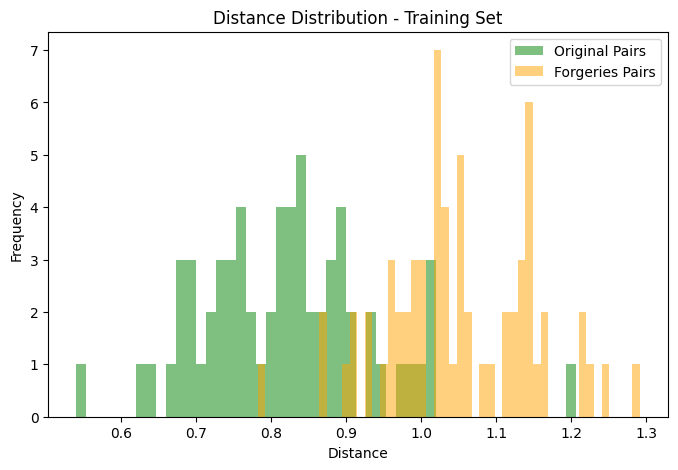

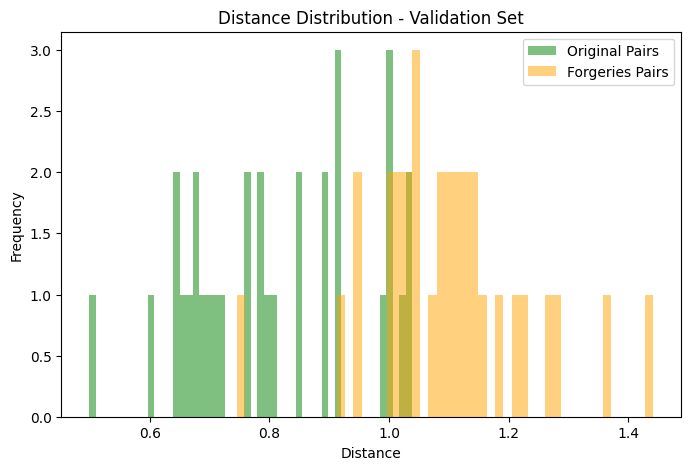

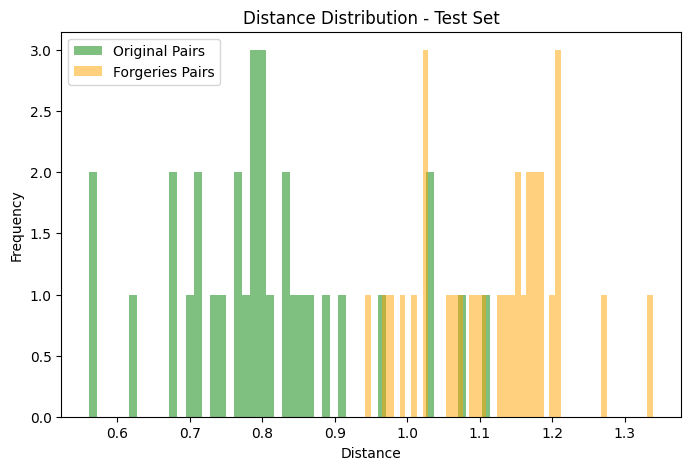

In [25]:
def plot_distances(pos_dist, neg_dist, title):
    plt.figure(figsize=(8, 5))
    plt.hist(pos_dist, bins=50, alpha=0.5, label='Original Pairs', color='green')
    plt.hist(neg_dist, bins=50, alpha=0.5, label='Forgeries Pairs', color='orange')
    plt.title(title)
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_distances(train_dist_pos, train_dist_neg, "Distance Distribution - Training Set")
plot_distances(val_dist_pos, val_dist_neg, "Distance Distribution - Validation Set")
plot_distances(test_dist_pos, test_dist_neg, "Distance Distribution - Test Set")



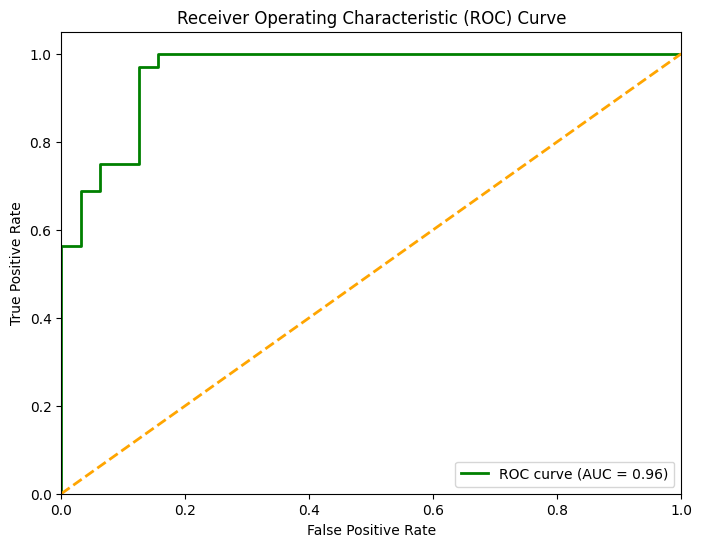

Optimal threshold: 0.9664
True Positive Rate at optimal threshold: 0.9688
False Positive Rate at optimal threshold: 0.1250


In [26]:
def calculate_roc(pos_dist, neg_dist):
    y_true = np.concatenate([np.ones(len(pos_dist)), np.zeros(len(neg_dist))])
    y_score = np.concatenate([pos_dist, neg_dist])

    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=0)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc, thresholds

fpr, tpr, roc_auc, thresholds = calculate_roc(test_dist_pos, test_dist_neg)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"True Positive Rate at optimal threshold: {tpr[optimal_idx]:.4f}")
print(f"False Positive Rate at optimal threshold: {fpr[optimal_idx]:.4f}")